![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 18 - Long Short Term Memory.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 18 - Long Short Term Memory.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>

# Task 18 - Long Short Term Memory

In the previous exercise you implemented a Vanilla Recurrent Neural Network and applied it to image captioning. In this notebook you will implement the Long Short-Term Memory update rule and use it for image captioning.


The goals of this assignment are as follows:

* Understand the architecture of Long Short Term Memory (LSTM) and how they operate on sequences by sharing weights over time
* Understand and implement LSTMs 
* Understand how to sample from an LSTM language model at test-time
* Understand how to combine convolutional neural nets and recurrent nets to implement an image captioning system

Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = 1301170073
Nama = "Pratama Yoga S"

## --- end your code here ----

---
---
#[Part 0] Import Libraries 
As usual, a bit of setup

In [2]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import urllib.request, urllib.error, urllib.parse, os, tempfile
from imageio import imread
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize']      = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap']          = 'gray'

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=7)

---
## 1 - Helper Functions

Below are helper functions to check your implementation

---
### a. Sigmoid Function

A numerically stable version of the logistic sigmoid function. Use this sigmoid in LSTM

In [3]:
def sigmoid(x):
    pos_mask = (x >= 0)
    neg_mask = (x < 0)

    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])

    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    
    return top / (1 + z)

---
### b. Numerical Gradient Check

Functions to check the gradients from your implementation

a naive implementation of numerical gradient of $f$ at $x$


In [4]:
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):

    # evaluate function value at original point
    fx = f(x) 
    grad = np.zeros_like(x)

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:

        # evaluate function at x+h
        ix     = it.multi_index
        oldval = x[ix]
        x[ix]  = oldval + h   # increment by h
        fxph   = f(x)         # evalute f(x + h)
        x[ix]  = oldval - h
        fxmh   = f(x)         # evaluate f(x - h)
        x[ix]  = oldval       # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope

        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

---
### c. Array Gradient Check

Functions to check the array of gradients from your implementation

Evaluate a numeric gradient for a function that accepts a numpy    array and returns a numpy array.


In [5]:
def num_grad_array(f, x, df, h=1e-5):

    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:

        ix = it.multi_index
        oldval = x[ix]
        x[ix]  = oldval + h
        pos    = f(x).copy()
        x[ix]  = oldval - h
        neg    = f(x).copy()
        x[ix]  = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
        
    return grad


---
### d. Relative Error Function

Function to calculate difference between your matrix and our expected results

In [6]:
def rel_error(x, y):
  
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

---
### e. Download Image Funtion

Read an image from a URL. Returns a numpy array with the pixel data.

In [7]:
def image_from_url(url):
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())

        img = imread(fname)
        # os.remove(fname)
        
        return img

    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
        return Image.new('RGB', (64,64), color='LightGray')
        
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url) 
        return Image.new('RGB', (64,64), color='LightGray')


---
## 2 - Install h5py
The COCO dataset we will be using is stored in HDF5 format. To load HDF5 files, we will need to install the `h5py` Python package. 

So install it if it's not already installed

In [8]:
!pip install h5py

import h5py

---
---
# [Part 1] Microsoft COCO Dataset
Like the previous exercise, in this exercise we will also use the $2014$ release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning.

The dataset consists of $80,000$ training images and $40,000$ validation images, each annotated with $5$ captions written by workers on **Amazon Mechanical Turk**.

---
## 1 - Download Preprocessed Data

You already use this, so let's just skip the explanation and run the cell below to dwnload the Preprocessed Microsoft COCO Dataset.

In [9]:
!wget -O 'coco_downloader.py' 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/coco_downloader.py' -q

In [10]:
from coco_downloader import *

download_coco()

In [11]:
!unzip -o coco_captioning.zip

!rm coco_captioning.zip

Archive:  coco_captioning.zip
   creating: coco_captioning/
  inflating: coco_captioning/coco2014_captions.h5  
  inflating: coco_captioning/coco2014_vocab.json  
  inflating: coco_captioning/train2014_images.txt  
  inflating: coco_captioning/train2014_urls.txt  
  inflating: coco_captioning/train2014_vgg16_fc7.h5  
  inflating: coco_captioning/train2014_vgg16_fc7_pca.h5  
  inflating: coco_captioning/val2014_images.txt  
  inflating: coco_captioning/val2014_urls.txt  
  inflating: coco_captioning/val2014_vgg16_fc7.h5  
  inflating: coco_captioning/val2014_vgg16_fc7_pca.h5  


---
## 2 - Text Processing


In [12]:
def decode_captions(captions, idx_to_word):
  
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]

    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]

    return decoded

---
## 3 - Load Coco Dataset



In [13]:
def load_coco_data(base_dir='coco_captioning', max_train=None, pca_features=True):

    data = {}
    
    # read caption encoding
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    # use original training features or pca-reduced features
    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    # use original validation features or pca-reduced features
    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    # read vocabulary token
    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    # read training image urls
    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    # read validation image urls
    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)

        data['train_captions']   = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data


Load COCO data from disk

In [14]:
data = load_coco_data(pca_features=True)

Print out all the keys and values from the data dictionary


In [15]:
p = ['  ', '', '    ','  ','  ','    ','     ','     ','      ','        ']
i=0
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k+p[i], type(v), v.shape, '\t', v.dtype)
    else:
        print(k+p[i], type(v), '\t', len(v))
    i += 1

train_captions   <class 'numpy.ndarray'> (400135, 17) 	 int32
train_image_idxs <class 'numpy.ndarray'> (400135,) 	 int32
val_captions     <class 'numpy.ndarray'> (195954, 17) 	 int32
val_image_idxs   <class 'numpy.ndarray'> (195954,) 	 int32
train_features   <class 'numpy.ndarray'> (82783, 512) 	 float32
val_features     <class 'numpy.ndarray'> (40504, 512) 	 float32
idx_to_word      <class 'list'> 	 1004
word_to_idx      <class 'dict'> 	 1004
train_urls       <class 'numpy.ndarray'> (82783,) 	 <U63
val_urls         <class 'numpy.ndarray'> (40504,) 	 <U63


---
## 4 - Look at the data


In [16]:
def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask       = np.random.choice(split_size, batch_size)

    captions       = data['%s_captions' % split][mask]
    image_idxs     = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    
    urls = data['%s_urls' % split][image_idxs]
    
    return captions, image_features, urls

 Sample a minibatch and show the images and captions

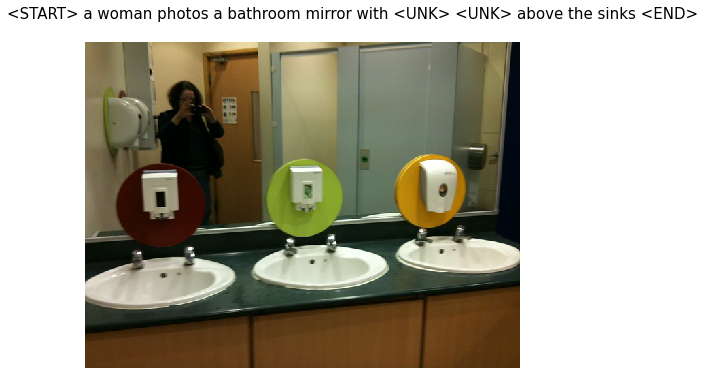


-----------------------------------------------------



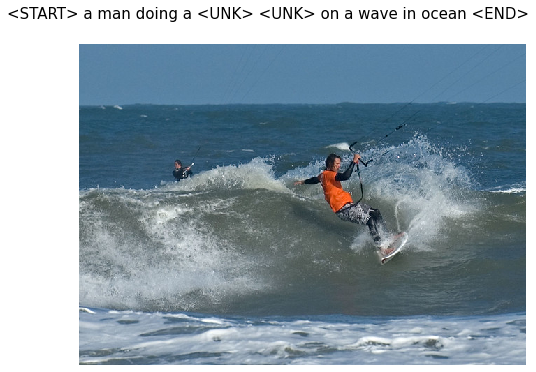


-----------------------------------------------------



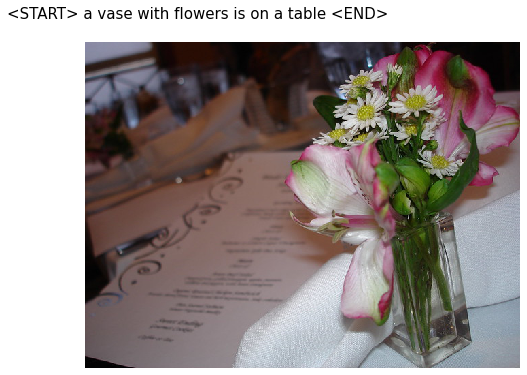


-----------------------------------------------------



In [17]:
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    caption_str = decode_captions(caption, data['idx_to_word'])

    fig = plt.figure(figsize=(8,6))
    fig.suptitle(caption_str, x=0, y=0.96, ha='left', size=15)

    plt.imshow(image_from_url(url))
    plt.axis('off')
    plt.show()
    
    print('\n-----------------------------------------------------\n')

run the cell again to view another set of images

You might also see that some of the images are already **removed** or **lost** from the Internet. 

But fear not since we have already retrieved all the feature for this training

---
# [Part 2] Long-Short Term Memory

If you read recent papers, you'll see that many people use a variant on the vanilla RNN called **Long-Short Term Memory (LSTM) RNNs**. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradients caused by repeated matrix multiplication.

LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

<center><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png' width=600></center>

Long Short Term Memory networks – usually just called “**LSTM**s” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
 



---
## 1 - LSTM Detailed

The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.

Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

<center><img src='https://i.ibb.co/fXRRrf2/lstm.png'></center>

Similar to the vanilla RNN, 
* At each timestep we receive an **input** &nbsp; $\color{firebrick} {x_t}\in\mathbb{R}^D$ and the **previous hidden state** &nbsp; $\color{tomato}{h_{t-1}}\in\mathbb{R}^H$; 

* The LSTM also maintains an $\color{tomato}H$-dimensional **cell state**, so we also receive the **previous cell state** $\color{tomato}{c_{t-1}}\in\mathbb{R}^H$. 

* The learnable parameters of the LSTM are an **input-to-hidden** matrix $\color{olive}{W_x}\in\mathbb{R}^{4H\times D}$, 

* A **hidden-to-hidden** matrix $\color{darkcyan}{W_h}\in\mathbb{R}^{4H\times H}$ and a **bias vector**&nbsp; $b\in\mathbb{R}^{4H}$.

<br>

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.


---
## 2 - Single Forward Step


First implement the `lstm_step_forward()` function which implements the forward pass for a **single timestep** of an LSTM.


At each timestep:
* We first compute an **Activation Vector**  from input, where $\color{blue}A \in \mathbb{R}^{N\times 4H}$ 

* In the code, we assume that data is stored in batches so that &nbsp;  $\color{firebrick}{X_t}  \in \mathbb{R}^{N\times D}$, &nbsp; and will work with *transposed* versions of the parameters: 


\begin{array}{ | c | c | }
\hline\rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{1pc} \color{olive}{W_x} \in \mathbb{R}^{D \times 4H} \hspace{1pc} & \hspace{1pc} \color{darkcyan}{W_h} \in \mathbb{R}^{H\times 4H} \hspace{1pc}\\
\hline
\end{array}


* so that activations $A$ can be computed efficiently as 

$$
\begin{array}{| c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
& \color{blue}A\ = \ \Big[\ \color{firebrick}{X_t} \cdot \color{olive}{W_x}\ \Big] \ +\ \ \Big[\  \color{tomato}{H_{prev}} \cdot \color{darkcyan}{W_h}\ \Big] \ +\ \ b & \\
\hline
\end{array}
\hspace{3pc}...(1)
$$

<br>




* We then compute the gates:

\begin{array}{| c | c | c | c |}
\hline
\textbf{input}\ gate &
\textbf{forget}\ gate &
\textbf{output}\ gate &
\textbf{intermediate}\ gate\\
\hline\rule{0pt}{2ex} \rule[-0.5em]{0pt}{1em}
\color{red}g & \color{red}f & \color{red}o & \color{red}i
\\
\hline
\end{array}

<br>

* From activation vector $A$, we can easily calculate the output gates by dividing it into four vectors &nbsp; $a_i,a_f,a_o,a_g\in\mathbb{R}^H$,&nbsp; <br>and feed it to each activation function as follow



$$
\begin{array}{| c | c | c | c |}
\hline
\rule{0pt}{4ex} \rule[-1em]{0pt}{1em} \hspace{0.5pc} 
\color{darkgreen}{i_t} = \sigma(a_i) \hspace{0.5pc}&\hspace{0.5pc}
\color{darkred}{f_t} = \sigma(a_f) \hspace{0.5pc}&\hspace{0.5pc}
\color{darkblue}{o_t} = \sigma(a_o) \hspace{0.5pc}&\hspace{0.5pc}
\color{purple}{g_t} = \tanh(a_g)  \hspace{0.5pc}\\
\hline
\end{array}
\hspace{3pc}...(2)
$$


* where $a_i$ consists of the first $H$ elements of $A$, $a_f$ is the next $H$ elements of $A$, and so on, like so:

$$
\begin{array}{| c c | c c |}
\hline
\rule{0pt}{4ex} \rule[-1em]{0pt}{1em}
\hspace{0.5pc}\color{darkgreen}{a_i} & = A[\ :\ ,\hspace{0.5pc}0:\hspace{0.5pc}H]\hspace{0.5pc}
&\hspace{0.5pc} \color{darkblue}{a_o} & = A[\ :\ ,\ 2H:3H]\hspace{0.5pc}\\
\hline
\rule{0pt}{4ex} \rule[-1em]{0pt}{1em}
\hspace{0.5pc}\color{darkred}{a_f} & = A[\ :\ ,\ H:2H]\hspace{0.5pc}
&\hspace{0.5pc} \color{purple}{a_g} & = A[\ :\ ,\ 3H:4H]\hspace{0.5pc}\\
\hline
\end{array}
$$


* Lastly, calculate the the next cell state $C_t$ and next hidden state $H_t$ as


$$
\begin{array}{c c}
\begin{array}{| c c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{1pc} C_{next} & = ( \color{darkred}{f_t} \odot  C_{prev} ) + ( \color{darkgreen}{i_t} \odot  \color{purple}{g_t} )  \hspace{1pc} \\
\hline
\end{array}
&\hspace{3pc}...(3)\\
\begin{array}{| c c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{2.5ex}H_{next} &= \color{darkblue}{o_t} \odot  \tanh(C_{next})\hspace{8.8ex}  \\
\hline
\end{array}
&\hspace{3pc}...(4)\\
\end{array}
$$



 * where $\odot $ is the element-wise product of vectors, and **NOT** the dot product

<br>


---
Check the illustration below to better understand the implementation

<center>
<img src='https://i.ibb.co/1z6SKqk/lstm-dot.png' width=800>
</center>

---
#### <font color='red'>**EXERCISE:** </font>
 
    Forward pass for a single timestep of an LSTM.
    The input data has dimension D, the hidden state has dimension H, and we use a minibatch size of N.




**Note:**    
<font color='red'>
* Use the `sigmoid()` function has already been provided for you in this file.
* Use `*` for element-wise multiplication ( $A\odot B $ ) or ( $A*B $ )
* Use `.dot()` for dot product ( $A\cdot B$ )
</font>

In [18]:
def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    
    N, H = prev_h.shape

    # 1. calculate activation as
    #    A = x dot Wx + prev_h dot Wh + b
    A = np.dot(x, Wx) + np.dot(prev_h, Wh) + b

    # 2. calculate each gate activation
    i = sigmoid( A[:, 0:H] )
    f = sigmoid( A[:, H:(H*2)] )
    o = sigmoid( A[:, (H*2):(H*3)] )
    g = np.tanh( A[:, (H*3):(H*4)] )

    # 3. calculate next cell activation as shown in the formula
    #    use * for elementwise product
    next_c = (f * prev_c) + (i * g)
    
    # 4. calculate next hidden activation as shown in the formula
    #    use * for elementwise product
    next_h = o * np.tanh(next_c)
    
    # store all necessary intermediate values for backwrd pass
    cache = (x, prev_h, prev_c, Wx, Wh, A, i, f, o, g, next_c, next_h)

    return next_h, next_c, cache


After doing so run the following to check your implementation. 
You should see errors on the order of `e-8` or less.

In [19]:
N, D, H = 3, 4, 5

x      = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx     = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh     = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b      = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

In [20]:
expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])

expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


**Expected Output**:
<pre>
next_h error:  5.7054131185818695e-09
next_c error:  5.8143123088804145e-09

---
## 3 - Single Backward Step

Next, implement the backward pass for a single step of an LSTM in `lstm_step_backward()` function below.

For sigmoid and tanh function, you can compute the local derivative in terms of the output value from `sigmoid` and `tanh`. 

\begin{array}{ | c | c | }
\hline\rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{0.5pc} \partial\tanh(x) = 1-\tanh^2(x) \hspace{0.5pc} & \hspace{0.5pc} \partial \sigma(x) = \sigma(x)*(1-\sigma(x)) \hspace{0.5pc}\\
\hline
\end{array}

<br>

As for the complete derivative of backward LSTM, we need to detailed it further into 4 steps

---
### a. Backward from $H_{next}$ 

<br>

The first is calculating gradient from next state.

You should see that if we going backward from $H_{next}$ output, we get element-wise product form output gate $o_t$ and $\tanh$ of cell state

<center>
<img src="https://i.ibb.co/nm8CB0w/dhnext.png"/>
</center>






* Thus, with &nbsp; 
$$
\begin{array}{| c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
& \partial \tanh(C) = 1-\tanh(C_{next})^2 \hspace{0.5pc}& \\
\hline
\end{array}
\hspace{2.5pc}...(1)
$$

* We can calculate the derivative as 

$$
\begin{array}{c c}
\hspace{5ex}
\begin{array}{| c c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{5.5ex}\partial o = \partial H_{next} * \tanh(C_{next})  \hspace{4ex} \\
\hline
\end{array}
&\hspace{1.5pc}...(2)\\
\hspace{5ex}
\begin{array}{| c c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{0.5pc}\partial C_{temp}= \partial H_{next}*o_t*\partial \tanh(C)\hspace{0.5pc} \\
\hline
\end{array}
&\hspace{1.5pc}...(3)\\
\end{array}
$$

* Note that we put the gradient of cell state $\partial C_{next}$ into a temporary matrix $ \partial C_{temp}$. 

* This was done since we need to accumulate it with the gradient from output cell state path. So now we need to do just that and add the gradients to 
$\partial C_{next}$
$$
\begin{array}{| c | }
\hline \rule{0pt}{4ex} \rule[-1em]{0pt}{1em} 
\hspace{1pc} \partial C_{next} = \partial C_{temp}+\partial C_{next}  \hspace{2pc} \\
\hline
\end{array}
\hspace{2.5pc}...(4)
$$

---
#### <font color='red'>**EXERCISE:** </font>
 
    calculate backward step from H_next = o * tanh(C_next)



**Note:**    
<font color='red'>
* Use the `sigmoid()` function has already been provided for you in this file.
* Use `*` for element-wise multiplication ( $A\odot B $ ) or ( $A*B $ )
* Use `.dot()` for dot product ( $A\cdot B$ )
</font>

In [21]:
def backward_step_a(dnext_h, dnext_c, next_c, o):
        
    # 1. calculate tanh local derivative
    dtanh_c = 1 - np.tanh(next_c)**2
    
    # 2. calculate o gate derivative as shown in the formula
    #    use * for elementwise product
    do = dnext_h * np.tanh(next_c)
    
    # 3. calculate C_temp derivative as shown in the formula
    #    use * for elementwise product
    dtemp_c = dnext_h * o * dtanh_c
    
    # 4. add dtemp_c to gradient highway dnext_c
    dnext_c =  dtemp_c + dnext_c
    
    return do, dnext_c

---
### b. Backward from $C_{next}$  

<br>

Next is calculating gradient from cell state.

Now this seems scary since we met all other gates, but actually not at all. 

<center>
<img src="https://i.ibb.co/Xk9630C/dcnext.png"/>
</center>

Remember that add operation is just passing gradients to all input. And since the rest are actually element-wise product, the derivatives are also element-wise product with the inputs' pair.

Thus we get each gates' gradients as:

$$
\begin{align*}
\partial i &= \partial C_{next} * g &\hspace{1pc}...\hspace{1pc}(1)\\
\partial g &= \partial C_{next} * i &\hspace{1pc}...\hspace{1pc}(2)\\
\partial f&= \partial C_{next} * C_{prev}&\hspace{1pc}...\hspace{1pc}(3)\\
\partial C_{prev} &= \partial C_{next} * f &\hspace{1pc}...\hspace{1pc}(4)\\
\\
\end{align*}
$$


---
#### <font color='red'>**EXERCISE:** </font>
 
    calculate backward step from C_next = (f * C_prev) + (i * g)



**Note:**    
<font color='red'>
* Use the `sigmoid()` function has already been provided for you in this file.
* Use `*` for element-wise multiplication ( $A\odot B $ ) or ( $A*B $ )
</font>

In [22]:
def backward_step_b(dnext_c, prev_c, i, f, g):
    
    # 1. calculate i gate derivative
    di = dnext_c * g
    
    # 2. calculate g gate derivative
    dg = dnext_c * i
    
    # 3. calculate f gate derivative
    df = dnext_c * prev_c
    
    # 4. calculate c_prev derivative
    dprev_c = dnext_c * f
    
    return di, df, dg, dprev_c

---
### c. Backward from Gates

<br>

Now calculate backward pass from all four gates to previous state $H_{prev}$ and input $X_t$

<center>
<img src="https://i.ibb.co/QvdfxpF/lstm2.png"/>
</center>

Thus we get each gates' gradients as:

$$
\begin{align*}
\\
\partial \sigma(i_t) &=  i * (1-i_t) &\hspace{0.5pc}...\hspace{0.5pc}(1)&\hspace{1pc}|\hspace{1pc}\partial a_i= \partial i_t * \partial \sigma(i_t)&\hspace{0.5pc}...\hspace{0.5pc}(5)\\\\
\partial \sigma(f_t) &= f * (1-f_t)&\hspace{0.5pc}...\hspace{0.5pc}(2)&\hspace{1pc}|\hspace{1pc}\partial a_f= \partial f_t * \partial \sigma(f_t)&\hspace{0.5pc}...\hspace{0.5pc}(6)\\\\
\partial \sigma(o_t) &=  o * (1-o_t)&\hspace{0.5pc}...\hspace{0.5pc}(3)&\hspace{1pc}|\hspace{1pc}\partial a_o= \partial o_t * \partial \sigma(o_t)&\hspace{0.5pc}...\hspace{0.5pc}(7)\\\\
\partial \tanh(g_t) &=1 - g_t^ 2&\hspace{0.5pc}...\hspace{0.5pc}(4)&\hspace{1pc}|\hspace{1pc}\partial a_g = \partial g_t * \partial \tanh(g_t)&\hspace{0.5pc}...\hspace{0.5pc}(8)\\\\
\end{align*}
$$


* where $\partial a_i$ consists of the first $H$ elements of $\partial A$; and $\partial a_f$ is the next $H$ elements of $\partial A$, and so on, like so:

$$
\begin{align*}
  \partial a_i & = \partial A[\ :\ ,\hspace{0.5pc}0:\hspace{0.5pc}H]\hspace{2pc}
& \partial a_o & = \partial A[\ :\ ,\ 2H:3H]\\
  \partial a_f & = \partial A[\ :\ ,\ H:2H]\hspace{2pc}
& \partial a_g & = \partial A[\ :\ ,\ 3H:4H]
\\\\
\end{align*}
$$

---
#### <font color='red'>**EXERCISE:** </font>
 
    calculate backward step from all four gates to A



**Note:**    
<font color='red'>
* Use the `sigmoid()` function has already been provided for you in this file.
* Use `*` for element-wise multiplication ( $A\odot B $ ) or ( $A*B $ )
</font>

In [23]:
def backward_step_c(di, df, do, dg, A, i, f, o, g):
  
    N, H = dg.shape    
    
    # create matrix zeros with size (N, 4*H)
    dA = np.zeros((N, 4*H))
    
    # 1. calculate sigmoid local derivative from gate i
    dsigm_i = i * (1-i)
    
    # 2. calculate sigmoid local derivative from gate f
    dsigm_f = f * (1-f)

    # 3. calculate sigmoid local derivative from gate o
    dsigm_o = o * (1-o)

    # 4. calculate tanh local derivative from gate g
    dtanh_g = 1 - (g**2)


    # 5. calculate derivative from gate i
    dA[:, :H] = di * dsigm_i
    
    # 6. calculate derivative from gate f
    dA[:, H:2*H] = df * dsigm_f

    # 7. calculate derivative from gate o
    dA[:, 2*H:3*H] = do * dsigm_o

    # 8. calculate derivative from gate g
    dA[:, 3*H:] = dg * dtanh_g


    return dA
    

---
### d. Backward from $A$

<br>

Lastly, we calculate the weights $W_x$ and $W_h$ gradients

<center>
<img src="https://i.ibb.co/QvdfxpF/lstm2.png" width=400/>

<br>
</center>

From forward pass 
<font color='blue'>$A$ </font>$ = $ <font color='firebrick'>$X_t$</font>$\cdot$ <font color='olive'> $W_x$ </font> $ + $<font color='tomato'>$H_{prev}$</font> $\cdot$<font color='darkcyan'> $W_h$</font>$ + b$ 

We got the derivatives as


$$
\begin{align*}
\\
\partial X_t&= \partial A \cdot (W_x)^T 
  & \hspace{0.5pc} ... \hspace{0.5pc}(1) 
  & \hspace{1pc}|\hspace{1pc}
  \partial H_{prev}=\partial A \cdot (W_h)^T
  & \hspace{0.5pc}...\hspace{0.5pc}(3)\\
\\
\partial W_x&=(X_t)^T \cdot \partial A
  & \hspace{1pc}...\hspace{0.5pc}(2)
  & \hspace{1pc}|\hspace{1pc}
  \partial W_h=(H_{prev})^T\cdot\partial A
  & \hspace{0.5pc}...\hspace{0.5pc}(4)
\end{align*}
$$

$$
\begin{align*}
\\
\partial b&=\sum(\partial A)& \hspace{1pc}...\hspace{0.5pc}(5)\\
\end{align*}
$$

<br>

---
#### <font color='red'>**EXERCISE:** </font>
 
    calculate backward step from A to weights



**Note:**    
<font color='red'>
* Use the `sigmoid()` function has already been provided for you in this file.
* Use `.dot()` for dot product ( $A\cdot B$ )
</font>

In [24]:
def backward_step_d(dA, Wx, Wh, x, prev_h):

    # calculate backward step from a = xWx + prev_hWh + b
    
    # 1. calculate x derivative
    dx = np.dot(dA, Wx.T)
    
    # 2. calculate Wx derivative
    dWx = np.dot(x.T, dA)
    
    # 3. calculate prev_h derivative
    dprev_h = np.dot(dA, Wh.T)
    
    # 4. calculate Wh derivative
    dWh = np.dot(prev_h.T, dA)
    
    # 5. calculate bias derivative, use np.sum with axis=0
    db = np.sum(dA, axis=0)
    
    return dx, dWx, dprev_h, dWh, db

---
### e. Complete Backward Step

Combine all steps into one LSTM backward step below

---
#### <font color='red'>**EXERCISE:** </font>
 
    implement backward step LSTM


In [25]:
def lstm_step_backward(dnext_h, dnext_c, cache):
    
    x, prev_h, prev_c, Wx, Wh, A, i, f, o, g, next_c, next_h = cache

    # get N and H
    N, H = dnext_h.shape

    
    # Backward step A
    # call backward_step_a() function with input dnext_h, dnext_c, next_c, and o
    do, dnext_c = backward_step_a(dnext_h, dnext_c, next_c, o)
    
    
    # Backward step B
    # call backward_step_b() function with input dnext_c, prev_c, i, f, and g
    di, df, dg, dprev_c = backward_step_b(dnext_c, prev_c, i, f, g)
    
    
    # Backward step C
    # call backward_step_c() function with input di, df, do, dg, a, i, f, o, and g
    dA = backward_step_c(di, df, do, dg, A, i, f, o, g)

    # Backward step D    
    # call backward_step_d() function with input dA, Wx, Wh, x, and prev_h
    dx, dWx, dprev_h, dWh, db = backward_step_d(dA, Wx, Wh, x, prev_h)


    return dx, dprev_h, dprev_c, dWx, dWh, db



After doing so run the following to numerically gradient check your implementation. You should see errors on the order of `e-8` or less.

In [26]:
np.random.seed(231)
N, D, H = 4, 5, 6

x      = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx     = np.random.randn(D, 4 * H)
Wh     = np.random.randn(H, 4 * H)
b      = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)


In [27]:
np.random.seed(231)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h  = lambda x:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h  = lambda h:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h  = lambda c:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h  = lambda b:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c  = lambda x:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c  = lambda h:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c  = lambda c:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c  = lambda b:  lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

dx_num  = num_grad_array(fx_h,   x, dnext_h) + num_grad_array(fx_c, x, dnext_c)
dh_num  = num_grad_array(fh_h, prev_h, dnext_h) + num_grad_array(fh_c, prev_h, dnext_c)
dc_num  = num_grad_array(fc_h, prev_c, dnext_h) + num_grad_array(fc_c, prev_c, dnext_c)
dWx_num = num_grad_array(fWx_h, Wx, dnext_h) + num_grad_array(fWx_c, Wx, dnext_c)
dWh_num = num_grad_array(fWh_h, Wh, dnext_h) + num_grad_array(fWh_c, Wh, dnext_c)
db_num  = num_grad_array(fb_h,   b, dnext_h) + num_grad_array(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)


In [28]:
print('dx error  : ', rel_error(dx_num, dx))
print('dh error  : ', rel_error(dh_num, dh))
print('dc error  : ', rel_error(dc_num, dc))
print('dWx error : ', rel_error(dWx_num, dWx))
print('dWh error : ', rel_error(dWh_num, dWh))
print('db error  : ', rel_error(db_num, db))

dx error  :  1.2120559407420112e-09
dh error  :  2.423350410468521e-10
dc error  :  1.1811747138523406e-08
dWx error :  1.6842746743670454e-09
dWh error :  5.570851510737813e-09
db error  :  3.643760111307456e-10


**Expected Output**:
<pre>
dx error  :  1.2120559407420112e-09
dh error  :  2.423350410468521e-10
dc error  :  1.1811747138523406e-08
dWx error :  1.6842746743670454e-09
dWh error :  5.570851510737813e-09
db error  :  3.643760111307456e-10

---
## 4 - Forward Pass
Now that you have implemented the forward and backward passes for a single timestep of an LSTM, you will combine these pieces to implement an LSTM that processes an entire sequence of data.

Implement Forward pass for an LSTM over an entire sequence of data. We assume an input   sequence composed of $T$ vectors, each of dimension $D$. 

The LSTM uses a hidden    size of $H$, and we work over a minibatch containing $N$ sequences. 

After running    the LSTM forward, we return the hidden states for all timesteps.

Note that the initial cell state is passed as input, but the initial cell    state is set to zero. Also note that the cell state is not returned; it is    an internal variable to the LSTM and is not accessed from outside.

---
#### <font color='red'>**EXERCISE:** </font>
Implement forward pass for an LSTM running on a sequence of input data.


In [29]:
def lstm_forward(x, h0, Wx, Wh, b):

    # get the size of N, T, H, and D
    N, T, D = x.shape
    N, H    = h0.shape  
    
    # create matrix zeros with size (N, T, H)
    h = np.zeros((N, T, H))
    
    # set h0 as previous hidden activation 
    prev_h =  h0

    # Initial cell state
    # create matrix zeros with size (N, H)
    next_c = np.zeros((N, H))

    #initialize cache dictionary
    cache = {}    
        
    
    # start LSTM forward 
    # loop over the timestep
    for i in range(T):

        # select x at timestep i 
        xt = x[:, i, :]  
        
        # call lstm_step_forward function with input xt, prev_h, next_c, and its weights
        current_h, next_c, cache_i = lstm_step_forward(xt, prev_h, next_c, Wx, Wh, b)
        
        # store the current hidden activation current_h to the i-th timestep in matrix h
        h[:, i, :] = current_h      
        
        # store the cache_i result to dictionary
        cache[i] = cache_i 
        
        # for the next iteration, 
        # set current hidden activation current_h as previous activation
        prev_h = current_h 
        
        
    return h, cache


After doing so run the following to check your implementation. 
You should see errors on the order of `e-7` or less.

In [30]:
N, D, H, T = 2, 5, 4, 3

x  = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b  = np.linspace( 0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

In [31]:
expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.610537452106624e-08


**Expected Output**:
<pre>
h error:  8.610537452106624e-08


---
## 5 - Backward Pass

Implement the backward pass for an LSTM running an entire sequence of data in the function `lstm_backward()`. 

This should run back-propagation over the entire sequence, making calls to the `lstm_step_backward` function that you defined earlier. 

**NOTE**:<br>`dh` contains the upstream gradients produced by the individual loss functions at each timestep,
and ***NOT*** the gradients being passed between timesteps <br>(which you'll have to compute yourself by calling `lstm_step_backward` in a loop).


---
#### <font color='red'>**EXERCISE:** </font>
Implement forward pass for an LSTM running on a sequence of input data.


In [35]:
def lstm_backward(dh, cache):

    # get the x data and D dimension
    x = cache[0][0]
    D = x.shape[1]
    
    # get the size of N, T, and H
    N, T, H = dh.shape
    
    # initialize zeros matrix with the appropriate size
    # Note that dWx, dWh, and bias width is 4H
    dx  = np.zeros((N, T, D)) # zeros shape (N, T, D)
    dh0 = np.zeros((N, H)) # zeros shape (N, H)
    dWx = np.zeros((D, 4*H)) # zeros shape (D, 4H)
    dWh = np.zeros((H, 4*H)) # zeros shape (H, 4H)
    db  = np.zeros(4*H) # zeros shape (4H)



    # initialzie zeros matrix for the current gradient h and cell c for the loop
    # all is sized (N, H) 
    dprev_c = np.zeros((N, H))
    dprev_h = np.zeros((N, H))

     
    # backward loop over timestep
    for i in reversed(range(T)):
        
        # select dh at timestep i        
        dht = dh[:, i, :]
        
        # gradient of next_h is the total of dht and dprev_h
        dnext_h = dht + dprev_h
        
        # set dprev_c as the next gradient
        dnext_c = dprev_c
        
        # get i-th cache from cache dictionary
        cache_i = cache[i]

        # call lstm_step_backward() with input dnext_h, dnext_c, and cache_i
        dx[:, i, :], dprev_h, dprev_c, dWx_t, dWh_t, db_t = lstm_step_backward(dnext_h, dnext_c, cache_i)

        # accumulate weight gradient over loop dWx_t into dWx
        dWx = dWx + dWx_t
        
        # accumulate weight gradient over loop dWh_t into dWh
        dWx = dWh + dWh_t
        
        # accumulate bias gradient over loop db_t into db
        db  = db + db_t

    # store the last gradient of hidden state as dh0
    dh0 = dprev_h

    return dx, dh0, dWx, dWh, db
    

Test your implementation. You should see errors on the order of `e-8` or less.
For dWh, it's fine if your error is on the order of e-6 or less

In [36]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 6

x  = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b  = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

In [37]:
np.random.seed(231)
dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx  = lambda x:  lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb  = lambda b:  lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num  = num_grad_array(fx,   x, dout)
dh0_num = num_grad_array(fh0, h0, dout)
dWx_num = num_grad_array(fWx, Wx, dout)
dWh_num = num_grad_array(fWh, Wh, dout)
db_num  = num_grad_array(fb,   b, dout)

print('dx error  : ', rel_error(dx_num, dx))
print('dh0 error : ', rel_error(dh0_num, dh0))
print('dWx error : ', rel_error(dWx_num, dWx))
print('dWh error : ', rel_error(dWh_num, dWh))
print('db error  : ', rel_error(db_num, db))

ValueError: ignored

**Expected Output**:
<pre>
dx error  :  6.56688634275682e-10
dh0 error :  6.8284665719089884e-09
dWx error :  2.0705351060661793e-09
dWh error :  3.452581713210269e-07
db error  :  1.6341597938420703e-09


---
---
# [Part 3] Temporal Affine Layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. 

This is very similar to the affine layer that you implemented in previous assignments, so complete the `temporal_affine_forward` and `temporal_affine_backward` functions below. 

---
## 1 - Forward Pass
Forward pass for a temporal affine layer. 

The input is a set of $D$-dimensional     vectors arranged into a minibatch of $N$ timeseries, each of length $T$. 

We use     an affine function to transform each of those vectors into a new vector of     dimension $M$.

---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [ ]:
def temporal_affine_forward(x, w, b):

    # get the size of N, T, and D
    N, T, D = x.shape

    # get the size of M
    M = b.shape[0]

    # reshape x into shape (N*T, D)
    x_reshape = x.reshpae((N*T, D))

    # output = dot product x_reshape with w
    out = np.dot(x_reshape, w)
    
    # reshape output into shape (N, T, M)
    out = out.reshpae((N, T, M))
    
    # add output with bias b
    out += b

    # store cache for backward pass
    cache = x, w, b, out

    return out, cache

---
## 2 - Backward Pass Pass

Backward pass for a temporal affine layer. 

Again, it's very much alike normal affine layer, but with temporal input shape

Thus you need to reshape the matrix to the appropriate shape before calculating dot product


---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [ ]:
def temporal_affine_backward(dout, cache):
  
    # extract cache
    x, w, b, out = cache

    # get the size of N, T, and D
    N, T, D = x.shape

    # get the size of M
    M = b.shape[0]

    # reshape dout into shape (N*T, M)
    dout_reshape = dout.reshape((N*T, M))

    # reshape x into shape (N*T, D)
    x_reshape = x.reshpaer((N*T, D))

    # dx = dot product dout_reshape with w.transpose
    dx = np.dot(dout_reshape, w.T)
    
    # reshape dx back into shape (N, T, D)
    dx = dx.reshape((N, T, D))
    
    # dw = dot product dout_reshape.transpose with x_reshape
    dw = np.dot(dout_reshape.T, x_reshape)

    # transpose back dw
    dw = dw.T

    # sum dout over axis=(0,1)
    db = dout.sum(axis=(0, 1))

    return dx, dw, db

---
## 3 - Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in previous assignment, we have implemented this loss function for you; look at the `temporal_softmax_loss` function below.

We assume that we are     making predictions over a vocabulary of size $V$ for each timestep of a    timeseries of length $T$, over a minibatch of size $N$. 

The input $x$ gives scores    for all vocabulary elements at all timesteps, and $y$ gives the indices of the    ground-truth element at each timestep. 

We use a cross-entropy loss at each    timestep, summing the loss over all timesteps and averaging across the    minibatch.

As an additional complication, we may want to ignore the model output at some
timesteps, since sequences of different length may have been combined into a
minibatch and padded with NULL tokens. The optional mask argument tells us
which elements should contribute to the loss.


In [ ]:
def temporal_softmax_loss(x, y, mask, verbose=False):

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    
    mask_flat = mask.reshape(N * T)

    probs  = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss   = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N

    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]

    if verbose: print('dx_flat: ', dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)

    return loss, dx

---
---
# [Part 4] Helper Functions

To further implement the image captioning process, we need several other funtions, such as Affine Layer functions and Optimizer functions. Which you have already made before.

Thus for the rest of the function, we've provided you with the implementation

But let's walk through each of them

---
## 1 - Word Embedding
In deep learning systems, we commonly represent words using vectors. 

Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Below we've provided you with the simple implementation of Forward and Backward pass of Word Embedding

---
### a. Forward Pass

Function `word_embedding_forward` below is the implementation of the forward pass for word embeddings. 

The function will convert words (represented by integers) into vectors. 

* operate on minibatches of size $N$ where    each sequence has length $T$.

* assume a vocabulary of $V$ words, assigning each    word to a vector of dimension $D$.


In [ ]:
def word_embedding_forward(x, W):
    
    out   = W[x, :]
    cache = x, W

    return out, cache

---
### b. Backward Pass
Function `word_embedding_backward` below is the implementation of the backward pass for the word embedding.

We cannot back-propagate into the words     since they are integers, so we only return gradient for the word embedding     matrix.

In [ ]:
def word_embedding_backward(dout, cache):

    x, W = cache
    dW   = np.zeros_like(W)
    
    np.add.at(dW, x, dout)

    return dW

---
## 2 - Affine Functions

Affine implementation as you have implemented in previous assignments

---
### a. Forward Pass

Computes the forward pass for an affine (fully-connected) layer.

The input $x$ has shape $(N, d_1, ..., d_k)$ where $x[i]$ is the $i^{th}$ input.

We multiply this against a weight matrix of shape $(D, M)$ 

In [ ]:
def affine_forward(x, w, b):
  
    out   = x.reshape(x.shape[0], -1).dot(w) + b
    cache = (x, w, b)

    return out, cache

---
### b. Backward Pass

Computes the backward pass for an affine layer.

In [ ]:
def affine_backward(dout, cache):

    x, w, b = cache

    dx = dout.dot(w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T.dot(dout)
    db = np.sum(dout, axis=0)
    
    return dx, dw, db

---
## 3 - Optimizer Functions

Here we also provide you with `SGD` and `Adam` optimization function

---
### a. SGD Optimizer
 Performs vanilla stochastic gradient descent.


In [ ]:
def sgd(w, dw, config=None):

    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw

    return w, config

---
### b. Adam Optimizer
Uses the Adam update rule, which incorporates moving averages of both the     gradient and its square and a bias correction term.


In [ ]:
def adam(x, dx, config=None):

    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 0)

    next_x = None
    beta1, beta2, eps = config['beta1'], config['beta2'], config['epsilon']
    t, m, v = config['t'], config['m'], config['v']

    m = beta1 * m + (1 - beta1) * dx
    v = beta2 * v + (1 - beta2) * (dx * dx)
    t += 1

    alpha = config['learning_rate'] * np.sqrt(1 - beta2 ** t) / (1 - beta1 ** t)

    x -= alpha * (m / (np.sqrt(v) + eps))

    config['t'] = t
    config['m'] = m
    config['v'] = v

    next_x = x

    return next_x, config

---
---
# [Part 5] LSTM for image captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. 


Implement the forward and backward pass of the model in the `loss` function. 

After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

---
## 1 - Weights Initialization Function

below is the cuntion to initialize weights of the LSTM

In [ ]:
def init_weights(word_to_idx, input_dim=512, wordvec_dim=128, hidden_dim=128, dtype=np.float32):
    
    vocab_size = len(word_to_idx)
    idx_to_word = {i: w for w, i in word_to_idx.items()}
    weights = {}

    # Initialize word vectors
    # Word embedding matrix
    weights['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
    weights['W_embed'] /= 100

    # Initialize CNN -> hidden state projection parameters    
    # Weight and bias for the affine transform from image features to initial
    # hidden state
    weights['W_proj'] = np.random.randn(input_dim, hidden_dim)
    weights['W_proj'] /= np.sqrt(input_dim)
    weights['b_proj'] = np.zeros(hidden_dim)

    # Initialize parameters for the LSTM
    # Input-to-hidden, hidden-to-hidden, and biases for the LSTM
    # dim_mul = {'lstm': 4, 'rnn': 1}
    dim_mul = 4
    weights['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
    weights['Wx'] /= np.sqrt(wordvec_dim)
    weights['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
    weights['Wh'] /= np.sqrt(hidden_dim)
    weights['b'] = np.zeros(dim_mul * hidden_dim)

    # Initialize output to vocab weights
    # Weight and bias for the hidden-to-vocab transformation.
    weights['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
    weights['W_vocab'] /= np.sqrt(hidden_dim)
    weights['b_vocab'] = np.zeros(vocab_size)

    # Cast parameters to correct dtype
    for k, v in weights.items():
        weights[k] = v.astype(dtype)

    return weights

---
## 2 - Captioning Step


Implement the forward and backward passes for the RNN Model.

In the forward pass you will need to do the following:                   
* Use an affine transformation to compute the initial hidden state from the image features. <br>This should produce an array of shape `(N, H)`

* Use a word embedding layer to transform the words in captions_in from indices to vectors, <br>giving an array of shape `(N, T, W)`.         
* Use a LSTM to process the sequence of input word vectors and produce hidden state vectors for all timesteps, <br>producing an array of shape `(N, T, H)`.
* Use a (temporal) affine transformation to compute scores over the vocabulary at every timestep using the hidden states, giving an array of shape `(N, T, V)`.                                            
* Use (temporal) softmax to compute loss using captions_out, <br>ignoring the points where the output word is `<NULL>` using the mask defined.     
                                                                         
In the backward pass you will need to compute the gradient of the loss with respect to all model parameters.
* `grads[k]` should give the gradients for `weights[k]`.

---
#### <font color='red'>**EXERCISE:** </font>

implement the function as described above

In [ ]:
def lstm_step(weights, features, captions, word_to_idx):
  
    # create special token
    token_null  = word_to_idx['<NULL>']
    token_start = word_to_idx.get('<START>', None)
    token_end   = word_to_idx.get('<END>', None)


    # Cut captions into two pieces: 
    #   captions_in has everything but the last word and will be input to the RNN; 
    #   captions_out has everything but the first word and this is what we will expect the RNN to generate. 

    # These are offset by one relative to each other because the RNN should produce word (t+1)
    # after receiving word t. 

    # The first element of captions_in will be the START token, 
    # and the first element of captions_out will be the first word.
    captions_in  = captions[:, :-1]
    captions_out = captions[:, 1:]

    # mask to calculate temporal softmax loss
    mask = (captions_out != token_null)

    # Weight and bias for the affine transform from image features to initial
    # hidden state
    W_proj, b_proj = weights['W_proj'], weights['b_proj']

    # Word embedding matrix
    W_embed = weights['W_embed']

    # Input-to-hidden, hidden-to-hidden, and biases for the LSTM
    Wx, Wh, b = weights['Wx'], weights['Wh'], weights['b']

    # Weight and bias for the hidden-to-vocab transformation.
    W_vocab, b_vocab = weights['W_vocab'], weights['b_vocab']
    
    # initialize gradients dictionary
    grads = {}
    
    ############################################################################
    # TODO: Implement the forward and backward passes for the CaptioningLSTM.  #
    ############################################################################
    
    # ------------------------------------------------
    # Forward Pass
    # ------------------------------------------------
    
    # (1) project the input image feature into hidden vector
    # call affine_forward() function with input features, with W_proj and b_proj as the projection weights
    hidden_init, cache_init = ??

    # (2) convert the caption of image batch into word embedding
    # call word_embedding_forward() function with input caption_in and W_embed weight
    captions_in_init, cache_embed = ??

    # (3) LSTM Forward Pass
    # call lstm_forward() function with input captions_in_init and hidden_init
    # also pass the Wx, Wh, and bias b weights into the function
    hidden_lstm, cache_lstm = ??
    
    # (4) calculate temporal scores
    # call temporal_affine_forward() function with input hidden_lstm also W_vocab and b_vocab
    scores, cache_scores = ??
        
    # ------------------------------------------------
    # Calculate Temporal Softmax Loss
    # ------------------------------------------------
    # call temporal_softmax_loss() function with input scores, caption_out, and mask that was defined above
    loss, dscores = ??

   
    # ------------------------------------------------
    # Backward Pass
    # ------------------------------------------------   
        
    # (4) backward pass temporal affine
    # call temporal_affine_backward() function with input dscores and its appropriate cache (see the forward pass)
    dhidden_lstm, grads['W_vocab'], grads['b_vocab'] = ??

    # (3) LSTM Backward Pass
    # call lstm_backward() function with input dhidden_lstm and its appropriate cache (see the forward pass)
    dcaptions_in_init, dhidden_init, grads['Wx'], grads['Wh'], grads['b'] = ??


    # (2) backward pass embedding
    # call word_embedding_backward() function with input dcaption_in_init and its appropriate cache (see the forward pass)
    grads['W_embed'] = ??

    # (1) backward pass affine
    # call affine_backward() function with input dhidden_init and its appropriate cache (see the forward pass)
    dfeatures, grads['W_proj'], grads['b_proj'] = ??
    
    
    return loss, grads

After doing so, run the following to check your forward pass using a small test case; 

you should see error on the order of `e-10` or less.

In [ ]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}

V = len(word_to_idx)
T = 13

model = init_weights(word_to_idx, input_dim=D, wordvec_dim=W, hidden_dim=H, dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.items():
    model[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)
    
features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads   = lstm_step(model, features, captions, word_to_idx)
expected_loss = 9.82445935443

print('loss          : ', loss)
print('expected loss : ', expected_loss)
print('difference    : ', abs(loss - expected_loss))

**Expected Output**:
<pre>
loss          :  9.824459354432264
expected loss :  9.82445935443
difference    :  2.2648549702353193e-12

---
## 3 - Training Function


Here we also provide you the training function for the LSTM Captioning. 

Read through the `lstm_captioning_train()` function below; 

it should look very familiar. This is exactly the same with the previous `rnn_captioning_train()` function. The only difference is that we call `lstm_step()` function here


In [ ]:
def lstm_captioning_train(weights, data, word_to_idx, 
                          optimizer = sgd, optim_config={},
                          epochs=10, batch_size=100, lr_decay=1.0, 
                          print_every=10, verbose=1):
    tic = time.time()

    best_val_acc = 0
    best_params  = {}

    loss_history      = []
    train_acc_history = []
    val_acc_history   = []
    
    # Make a deep copy of the optim_config for each parameter
    optim_configs = {}
    for p in weights:
        d = {k: v for k, v in optim_config.items()}
        optim_configs[p] = d

    num_train = data['train_captions'].shape[0]

    # total iteration per epoch
    num_iter  = max(num_train // batch_size, 1)
    
    #start iteration counts
    it = 0

    # Start Train
    for ep in range(epochs):    

        # loop over batch iteration
        for i in range(num_iter):
        
            # ------------------------------------------------
            # 1. Sample Minibatch of Training Data
            # ------------------------------------------------
            captions, features, urls = sample_coco_minibatch(data, 
                                                             batch_size=batch_size, 
                                                             split='train')

            # ------------------------------------------------
            # 2. Compute loss and gradient
            # ------------------------------------------------
            loss, grads = lstm_step(weights, features, captions, word_to_idx)
            loss_history.append(loss)


            # ------------------------------------------------
            # 3. Parameter Update
            # ------------------------------------------------   
            # Perform a parameter update
            for p, w in weights.items():
                dw     = grads[p]
                config = optim_configs[p]

                next_w, next_config = optimizer(w, dw, config)
                weights[p]          = next_w
                optim_configs[p]    = next_config
            
            # iteration count
            it +=1

            # Maybe print training loss
            if verbose==1 and it % print_every == 0:
                print ('iteration',it,'(epoch', ep,'/',epochs, '): loss =', loss_history[-1])

        # At the end of one epoch:
        # Decay learning rate        
        for k in optim_configs:
            optim_configs[k]['learning_rate'] *= lr_decay


    print('Training Done')
    toc = time.time()
    print('Training Time:= %.2f seconds' % (toc-tic))
    print('Training Time:= %.2f minutes' % ((toc-tic)/60))
    
    return loss_history, weights

---
## 4 - Overfit small data

Once you have familiarized yourself with the function, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

First, initialize the model

In [ ]:
np.random.seed(231)

small_data = load_coco_data(max_train=70)

small_lstm_model = init_weights(
    word_to_idx = data['word_to_idx'], 
    input_dim   = data['train_features'].shape[1],
    wordvec_dim = 256, 
    hidden_dim  = 512,
    dtype=np.float32,
)

Overfit small data

In [ ]:
loss_history, small_lstm_model = lstm_captioning_train(
    small_lstm_model,
    data         = small_data, 
    word_to_idx  = data['word_to_idx'], 
    optimizer    = adam, 
    optim_config = {'learning_rate': 5e-3,},
    epochs       = 100,
    batch_size   = 128,
)


**EXPECTED OUTPUT**:
<pre>
    loss shoud start around 40 and end around 0.05
    in about 4 minutes

Plot the training losses

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

---
---
# [Part 6] LSTM Captioning Testing 
Unlike classification models, image captioning models behave very differently at training time and at test time. 

At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the LSTM at each timestep.

While at test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the LSTM at the next timestep.

Therefore we need to implement slightly different forward pass

---
## 1 - Forward Testing Function

Implement a test-time forward pass for the model, sampling captions for input feature vectors.

At each timestep, we embed the current word, pass it and the previous hidden state to the LSTM to get the next hidden state, use the hidden state to get scores for all vocab words, and choose the word with the highest score as the next word. The initial hidden state is computed by applying an affine transform to the input image features, and the initial word is the `<START>` token


You will need to initialize the hidden state of the LSTM by applying the learned affine transform to the input image features. The first word that you feed to the LSTM should be the `<START>` token; its value is stored in the variable `token_start`. 
    


First, you need to project the input feature. Then, at each timestep you will need to do to:  
 1. Embed the previous word using the learned word embeddings 

 2. Make an `LSTM step` using the previous hidden state and the embedded current word to get the next hidden state.
 3. Apply the learned affine transformation to the next hidden state to get scores for all words in the vocabulary                          
 4. Select the word with the `highest score` as the next word, writing it (the word index) to the appropriate slot in the captions variable   
                                                                        
For simplicity, you do not need to stop generating after an `<END>` token is sampled, but you can if you want to.                                 

NOTE: we are still working over minibatches in this function.      

---
#### <font color='red'>**EXERCISE:** </font>

Run a test-time forward pass for the model, sampling captions for input    feature vectors.

In [ ]:
def lstm_captioning_test(weights, features, word_to_idx, max_length=30):

    # create special token
    token_null  = word_to_idx['<NULL>']
    token_start = word_to_idx.get('<START>')
    token_end   = word_to_idx.get('<END>')
    
    N = features.shape[0]
    captions = token_null * np.ones((N, max_length), dtype=np.int32)

    # Unpack parameters
    W_proj, b_proj   = weights['W_proj'], weights['b_proj']
    W_embed          = weights['W_embed']
    Wx, Wh, b        = weights['Wx'], weights['Wh'], weights['b']
    W_vocab, b_vocab = weights['W_vocab'], weights['b_vocab']
    
    # (0) project the input image feature into current hidden vector
    # call affine_forward() function with input features, W_proj, and b_proj as the projection weights
    current_h, _ = ??

    
    # create zeros matrix with size the same as current_h
    current_c = np.zeros_like(current_h)

    # initialize array to accumulate the generated words
    words = np.zeros(N, dtype=int)
    words.fill(token_start)

    # start generating caption
    for step in range(max_length):
        
        # (1) Embedding the output word for the next iteration
        #     call word_embedding_forward() function with input words and W_embed weight
        word_embed, _ = ??
        
        # (2) Make an lstm step using the previous hidden state and the embedded current word to get the next hidden state;
        #     call lstm_step_forward() function with input word_embed, current_h, and current_c
        #     also pass the Wx, Wh, and bias b weights into the function
        current_h, current_c, _ = ??

        # (3) Apply the learned affine transformation to the next hidden state to get scores for all words in the vocabulary 
        #     call affine_forward() function with input current_h also W_vocab and b_vocab
        scores, _ = ??

        # (4) Select the word with the highest score as the next word
        #     use np.argmax() to scores with axis=1
        captions[:, step] = ??

        # store the generated caption as input word for the next iteration
        words = captions[:, step]
        
    return captions

---
## 2 - Image Captioning Testing Function

Now define function to load several image and generate the caption

In [ ]:
def generate_caption(model, data, split, batch_size):
    print('Generating Caption from ',split,'set images')
    print('-------------------------------------------')
    
    gt_captions, features, urls = sample_coco_minibatch(data, split=split, batch_size=batch_size)
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = lstm_captioning_test(model, features, data['word_to_idx'])
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        fig = plt.figure(figsize=(8,6))
        plt.imshow(image_from_url(url))
        fig.suptitle('Caption Result : %s\nGround Truth   : %s' % (sample_caption, gt_caption), x=0, y=0.96, ha='left', size=15)
        plt.axis('off')
        plt.show()
        print('\n-----------------------------------------------------\n')

    

---
## 3 - Test-time sampling

After you finish the testing function implementations, run the following to sample from your overfitted model on both training and validation data. 



---
### a. Test on Training Set

The samples on training data should be very good; 


In [ ]:
generate_caption(model=small_lstm_model, data=small_data, split='train', batch_size=3)

---
### b. Test on Validation  Set
The samples on validation data are still bad, but you should see that it's <font color='red'>much better than using Vanilla RNN</font>

In [ ]:
generate_caption(model=small_lstm_model, data=small_data, split='val', batch_size=3)

---
---
# [Part 7] Train your own model

* You can continue the training on bigger set of data and test it 
* Or you can change the model to a bigger model

---
## 1 - Get a bigger set of sample data

load a bigger sample set from coco dataset


In [ ]:
bigger_data = load_coco_data(max_train=500)

---
## 2 - Generate new and bigger Model
create a new model, or just use the previous model


In [ ]:
new_model = init_weights(
    word_to_idx = data['word_to_idx'], 
    input_dim   = data['train_features'].shape[1],
    wordvec_dim = 256, 
    hidden_dim  = 512,
    # dtype=np.float32,
)

---
## 3 - Train your model

you can generate new model

you can run this part over-and-over to overfit the data

In [ ]:
loss_history, new_model = lstm_captioning_train(
    new_model,
    data         = bigger_data, 
    word_to_idx  = data['word_to_idx'], 
    optimizer    = adam, 
    optim_config = {'learning_rate': 5e-3,},
    epochs       = 100,
    batch_size   = 64,
    lr_decay     = 0.99,
    print_every  = 20,
)

**EXPECTED OUTPUT**:
<pre>
    loss shoud start around 50 and end around 0.04
    in about 15 minutes

Plot the training losses

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

---
## 4 - Test the trained model

Now test it

Again, you should see that, compared to the Vanilla RNN, the results are much better 

---
### a. Test on Training Set

The samples on training data should be very good; 


In [ ]:
generate_caption(model=new_model, data=bigger_data, split='train', batch_size=5)

after several training step, you should see that the validation captioning is getting better

---
### b. Test on Validation  Set
You should see that some of the captions are starting to get it right



In [ ]:
generate_caption(model=new_model, data=bigger_data, split='val', batch_size=5)


You can train it more to increase the performance


---

# Congratulation, You've Completed Exercise 18
<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)